<a href="https://colab.research.google.com/github/newlightpooh/colab/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
import csv
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

In [ ]:
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn import metrics

In [ ]:
# connect to google drive
import glob
from google.colab import drive
drive.mount('/content/drive')

# current path
print(os.getcwd())

# show directory
# print(os.listdir())

# show directory in each path
# data_path = 'drive/My Drive/'
# print(os.listdir(data_path))

# filelist = os.listdir(data_path)
# for filename in filelist:
#   print(filename)

Mounted at /content/drive
/content


# define

In [ ]:
climb_direct = {
    'speed': ['CTUN_SAs', 'CTUN_As' ],
    'pitch': ['ATT_DesPitch', 'RATE_ADes', 'PSCD_TAD' , 'ATT_Pitch' , 'TECS_dh' ]
}

climb_turn = {
    'speed': ['IMU_AccX', 'TECS_sp', 'NTUN_AspdE' , 'TECS_dsp' , 'TECS_spdem' ],
    # 'pitch': ['ATT_Pitch', 'TECS_dh', 'AHR2_Pitch' , 'ATT_DesPitch' ]\
    'pitch': ['ATT_DesPitch', 'RATE_ADes', 'PSCD_TAD' , 'ATT_Pitch' , 'TECS_dh' , 'GPS_VZ']
}

noclimb_direct = {
    'speed': ['ARSP_Airspeed', 'TECS_spdem'],
    'pitch': ['ATT_DesPitch', 'ATT_Pitch', 'GPS_VZ' ],
    'yaw': ['ATT_DesYaw', 'AOA_SSA', 'XKY0_Y1' ]
}

noclimb_turn = {
    'roll': ['ATT_DesRoll', 'ATT_Roll'],
    'pitch': ['ATT_DesPitch', 'ATT_Pitch']
}

# climb_direct

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/climb+direct_phase.csv"

# print(filename)
all_parameter_df = pd.read_csv(filename,index_col=0)
all_parameter_df = all_parameter_df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)

In [ ]:
df = all_parameter_df
df.fillna(0, inplace=True)
df = df.loc[:, (df != 0).any(axis=0)] #ลบทุก column ที่ทุก row = 0

df_corr = df.copy()
correlation_all_parameter = df_corr.corr()

correlation_with_powr = correlation_all_parameter.loc[correlation_all_parameter.index != 'BAT_VoltCurr', 'BAT_VoltCurr'].to_frame()  #ในข้อมูลพี่ริว คือ 21
correlation_with_powr['Abs_Corr'] = correlation_with_powr["BAT_VoltCurr"].abs()

sorted_correlation_with_powr = correlation_with_powr.sort_values(by='Abs_Corr', ascending=False).copy()
sorted_correlation_with_powr.drop('Abs_Corr',axis = 1 ,inplace = True)
sorted_correlation_with_rank = sorted_correlation_with_powr.iloc[:100].copy()
sorted_correlation_with_rank.loc[:, 'rank'] = range(1, 101)
sorted_correlation_with_rank.drop('BAT_VoltCurr',axis = 1 ,inplace = True)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()]

column_names = g.columns

scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)

normalized_df = pd.DataFrame(normalized_data, columns=column_names)

transposed_df = normalized_df.transpose()

kmeans = KMeans(n_clusters=7)

transposed_df['Cluster'] = kmeans.fit_predict(transposed_df)

for cluster, data in transposed_df.groupby('Cluster'):
    print(f"Cluster {cluster}:\n{data.index.tolist()}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
['RCOU_C9', 'RCOU_C13', 'RCOU_C14', 'AETR_Thr', 'CTRL_RMSRollD', 'PIDP_FF', 'GPS_Spd', 'STAT_isFlyProb', 'ARSP_Airspeed', 'RCIN_C3', 'ARSP_DiffPress']

Cluster 1:
['CTUN_ThO', 'PSCD_TAD', 'PIQP_SRate', 'CTUN_SAs', 'CTUN_As', 'PIQR_SRate', 'XKF2_AZ', 'PIQA_Dmod', 'XKV2_V23', 'CAM_RelAlt', 'PSCD_TVD', 'XKF4_OFN', 'PIQY_I', 'CMD_Alt', 'XKY0_W2', 'XKF2_GSY', 'NK11_PD', 'XKF6_PD', 'NK12_GSZ', 'AUXF_function', 'XKV2_V22', 'XKF2_GSZ', 'XKF7_GSZ', 'MAG_MagZ', 'XKF7_GSY', 'NK12_ME', 'XKT_VMin']

Cluster 2:
['PIQA_Err', 'PIQA_P', 'PIQA_Tar', 'RATE_ADes', 'XKF1_dPD', 'XKF2_MX', 'XKF1_VD', 'RCOU_C10', 'RCOU_C2', 'GPS_VZ', 'QTUN_DCRt']

Cluster 3:
['BAT_Volt', 'BAT_Res', 'XKY0_YCS', 'XKV2_V13', 'CMD_CId', 'BAT_VoltR', 'XKV2_V14', 'XKY1_IVE3']

Cluster 4:
['BAT_Curr', 'IMU_AccX', 'ATT_DesPitch', 'CTUN_NavPitch', 'XKF1_Pitch', 'AHR2_Pitch', 'CTUN_Pitch', 'ATT_Pitch', 'CAM_Pitch', 'XKF3_IPD', 'PIDP_Tar', 'BARO_CRt', 'TECS_dh', 'POWR_VServo']

Cluster 5:
['CMD_CNum', 'XKF3_IVD', 'BAR2_Alt', 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

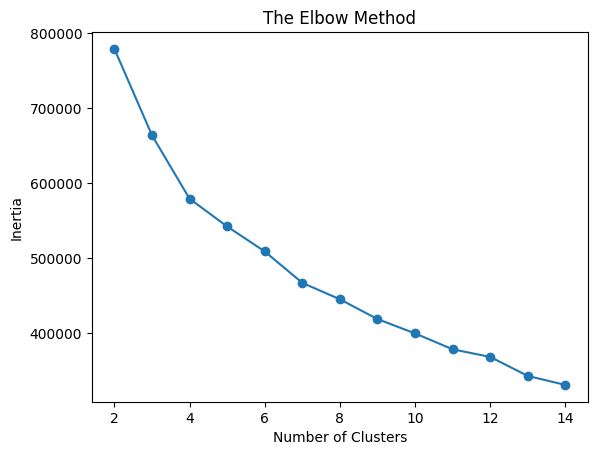

In [ ]:
inertia = []

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()].fillna(0)
column_names = g.columns
scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)
normalized_df = pd.DataFrame(normalized_data, columns=column_names)
transposed_df = normalized_df.transpose()

for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(transposed_df)  # หรือ df.T
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()



---



<ipython-input-62-790cea2612ab>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['CTUN_As'] = result_df['CTUN_As'].combine_first(df['CTUN_Aspd'])


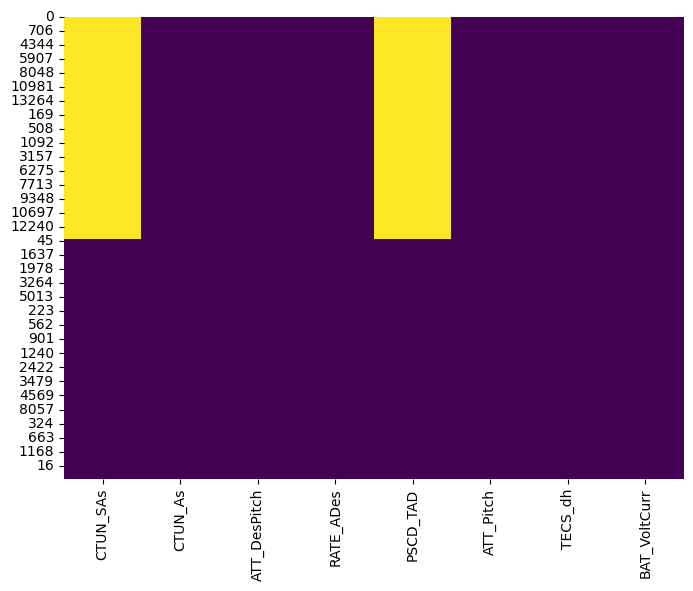

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/climb+direct_phase.csv"
df = pd.read_csv(filename,index_col=0)
selected_columns = [col for key, values in climb_direct.items() for col in values]
selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

#4.0.8
result_df['CTUN_As'] = result_df['CTUN_As'].combine_first(df['CTUN_Aspd'])

plt.figure(figsize=(8, 6))
sns.heatmap(result_df.isnull(), cmap='viridis', cbar=False)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_names = tuple(X.columns)

<ipython-input-63-3cac63c3d4fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestClassifier as rfc
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


sbs = SFS(#knn(n_neighbors=3),
           #rfc(n_jobs=8),
          # MLPClassifier(hidden_layer_sizes=1000),
           LinearRegression(),
           k_features='best',
           forward=False,
           floating=False,
           verbose=2,
           scoring = 'neg_mean_absolute_error',  # sklearn regressors
          #  scoring='accuracy',  # sklearn classifiers
           cv=3)
sbs = sbs.fit(X_scaled, y)


[2023-12-27 19:56:00] Features: 6/1 -- score: -233.33018236355187
[2023-12-27 19:56:00] Features: 5/1 -- score: -217.64145077603112
[2023-12-27 19:56:00] Features: 4/1 -- score: -214.5675951902225
[2023-12-27 19:56:00] Features: 3/1 -- score: -214.40203344309964
[2023-12-27 19:56:00] Features: 2/1 -- score: -222.3474755542101
[2023-12-27 19:56:00] Features: 1/1 -- score: -249.28053401657107

In [ ]:
df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df

,feature_idx,avg_score
7,"(0, 1, 2, 3, 4, 5, 6)",-257.035754
6,"(0, 1, 2, 3, 5, 6)",-233.330182
5,"(0, 1, 2, 3, 5)",-217.641451
4,"(0, 1, 2, 5)",-214.567595
3,"(0, 1, 2)",-214.402033
2,"(0, 2)",-222.347476
1,"(2,)",-249.280534


In [ ]:
sbs.subsets_


{7: {'feature_idx': (0, 1, 2, 3, 4, 5, 6),
  'cv_scores': array([-200.07255122, -236.2108023 , -334.82390889]),
  'avg_score': -257.0357541347385,
  'feature_names': ('CTUN_SAs',
   'CTUN_As',
   'ATT_DesPitch',
   'RATE_ADes',
   'PSCD_TAD',
   'ATT_Pitch',
   'TECS_dh')},
 6: {'feature_idx': (0, 1, 2, 3, 5, 6),
  'cv_scores': array([-201.16208192, -226.78063592, -272.04782925]),
  'avg_score': -233.33018236355187,
  'feature_names': ('CTUN_SAs',
   'CTUN_As',
   'ATT_DesPitch',
   'RATE_ADes',
   'ATT_Pitch',
   'TECS_dh')},
 5: {'feature_idx': (0, 1, 2, 3, 5),
  'cv_scores': array([-197.4693877 , -222.02732406, -233.42764058]),
  'avg_score': -217.64145077603112,
  'feature_names': ('CTUN_SAs',
   'CTUN_As',
   'ATT_DesPitch',
   'RATE_ADes',
   'ATT_Pitch')},
 4: {'feature_idx': (0, 1, 2, 5),
  'cv_scores': array([-200.45526362, -222.02631836, -221.2212036 ]),
  'avg_score': -214.5675951902225,
  'feature_names': ('CTUN_SAs', 'CTUN_As', 'ATT_DesPitch', 'ATT_Pitch')},
 3: {'feature_

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection

efs = ExhaustiveFeatureSelector(
           #knn(n_neighbors=3),
           #rfc(n_jobs=8),
           LinearRegression(),
          max_features=len(X.columns),
          scoring='neg_mean_absolute_error',  # ใช้ neg_mean_absolute_error
          cv=3,
          n_jobs=-1)

efs = efs.fit(X, y)


Features: 127/127

In [ ]:
efs.best_feature_names_


('CTUN_SAs', 'CTUN_As', 'ATT_DesPitch')

# climb_turn

In [ ]:
list_df = []

filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/climb+turn_phase.csv"

# print(filename)
all_parameter_df = pd.read_csv(filename,index_col=0)
all_parameter_df = all_parameter_df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)

df = all_parameter_df
df.fillna(0, inplace=True)
df = df.loc[:, (df != 0).any(axis=0)] #ลบทุก column ที่ทุก row = 0

df_corr = df.copy()
correlation_all_parameter = df_corr.corr()

correlation_with_powr = correlation_all_parameter.loc[correlation_all_parameter.index != 'BAT_VoltCurr', 'BAT_VoltCurr'].to_frame()  #ในข้อมูลพี่ริว คือ 21
correlation_with_powr['Abs_Corr'] = correlation_with_powr["BAT_VoltCurr"].abs()

sorted_correlation_with_powr = correlation_with_powr.sort_values(by='Abs_Corr', ascending=False).copy()
sorted_correlation_with_powr.drop('Abs_Corr',axis = 1 ,inplace = True)
sorted_correlation_with_rank = sorted_correlation_with_powr.iloc[:100].copy()
sorted_correlation_with_rank.loc[:, 'rank'] = range(1, 101)
sorted_correlation_with_rank.drop('BAT_VoltCurr',axis = 1 ,inplace = True)



In [ ]:
sorted_correlation_with_rank.index.tolist()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()]

column_names = g.columns

scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)

normalized_df = pd.DataFrame(normalized_data, columns=column_names)

In [ ]:
transposed_df = normalized_df.transpose()

kmeans = KMeans(n_clusters=5)

transposed_df['Cluster'] = kmeans.fit_predict(transposed_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
unique_clusters = transposed_df.iloc[:,-1].unique()
unique_clusters

array([4, 2, 3, 0, 1], dtype=int32)

In [ ]:
for cluster, data in transposed_df.groupby('Cluster'):
    print(f"Cluster {cluster}:\n{data.index.tolist()}\n")

Cluster 0:
['PM_I2CC', 'GPA_SMS', 'MAG_S', 'BARO_SMS', 'IOMC_TS', 'IOMC_NPkt', 'PM_SPIC', 'PIQA_Tar', 'PIQA_Err', 'PIQA_P', 'XKF1_dPD', 'NK13_IYAW', 'MAG2_S', 'BAR2_SMS', 'XKF7_MD', 'XKF8_IYAW', 'RATE_ADes', 'NK12_MD', 'XKF1_VD', 'XKF3_IYAW', 'GPS_VZ', 'BAR2_Alt', 'BAR2_GndTemp', 'NKT1_AngMin', 'NKT1_VMin', 'XKF9_errRP', 'PSCN_DAN', 'PSCN_TVN', 'PSCN_DVN', 'PSCN_VN']

Cluster 1:
['PSCD_TAD', 'XKV2_V23', 'CTUN_ThO', 'TECS_dh', 'TECS_spdem', 'RCIN_C1', 'XKF2_AZ', 'XKV2_V17', 'XKV2_V15', 'CMD_CId', 'RATE_ROut', 'AUXF_function', 'XKF6_PD', 'NK11_PD', 'PIDP_SRate', 'NK11_GZ', 'XKV1_V02', 'CAM_Yaw', 'XKV1_V10', 'XKV2_V12', 'PSCE_AE', 'PSCE_DAE', 'PSCE_DVE', 'PSCE_TVE']

Cluster 2:
['TECS_sp', 'NTUN_AspdE', 'TEC2_EDelta', 'BAT_EnrgTot', 'BAT_CurrTot', 'RAD_RxErrors', 'CTUN_ThrDem', 'RATE_P', 'MAVC_Cmd', 'MAG2_OfsY', 'XKF6_OH', 'NK11_OH', 'CTRL_RMSPitchD', 'RCIN_C5', 'ATT_ErrRP', 'QTUN_ABst']

Cluster 3:
['BAT_VoltR', 'PIQR_I', 'TECS_dsp', 'RCIN_C3', 'NK12_GSZ', 'XKF2_GSZ', 'XKF2_GSY', 'UBX1_a

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

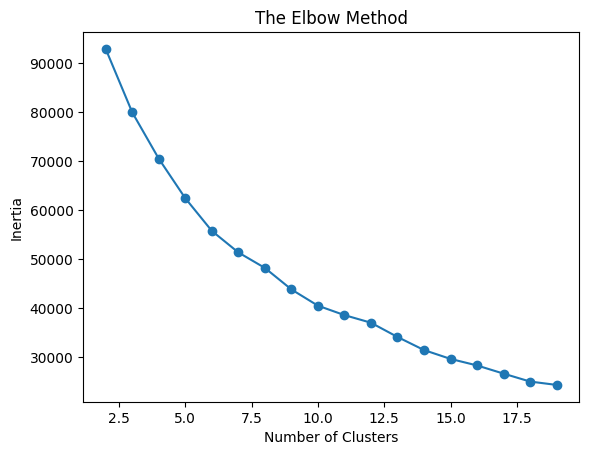

In [ ]:
inertia = []

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()]
column_names = g.columns
scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)
normalized_df = pd.DataFrame(normalized_data, columns=column_names)
transposed_df = normalized_df.transpose()

for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(transposed_df)  # หรือ df.T
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()




---



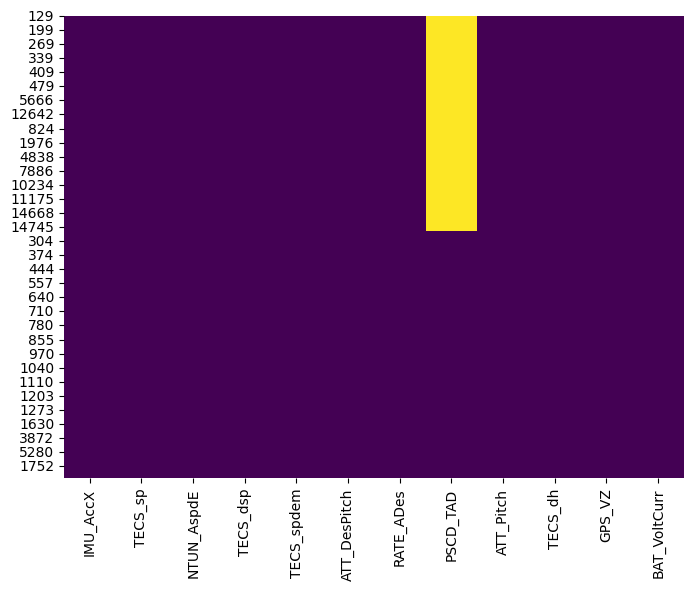

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/climb+turn_phase.csv"
df = pd.read_csv(filename,index_col=0)
selected_columns = [col for key, values in climb_turn.items() for col in values]
selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

plt.figure(figsize=(8, 6))
sns.heatmap(result_df.isnull(), cmap='viridis', cbar=False)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
feature_names = tuple(X.columns)


<ipython-input-86-5d634dbd1792>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
model = RandomForestRegressor()

model.fit(X, y)
feature_importance = model.feature_importances_
feature_importance

array([0.17337177, 0.71034214, 0.05681467, 0.0024186 , 0.00495301,
       0.0030636 , 0.00172249, 0.02665955, 0.00946797, 0.00197458,
       0.00921162])

In [ ]:
for feature, importance in zip(X.columns, feature_importance):
    print(f'{feature}: {importance}')

IMU_AccX: 0.18113125705502384
TECS_sp: 0.7062725651657039
NTUN_AspdE: 0.07480694057651754
TECS_dsp: 0.0026691284225829836
TECS_spdem: 0.008243674365285631
ATT_Pitch: 0.005332974679589321
TECS_dh: 0.004071406506772582
AHR2_Pitch: 0.009222753814726559
ATT_DesPitch: 0.00824929941379763


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestClassifier as rfc
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


sbs = SFS(#knn(n_neighbors=3),
           #rfc(n_jobs=8),
          # MLPRegressor(hidden_layer_sizes=(10, ), activation='relu', random_state=42),
           LinearRegression(),
          # RandomForestRegressor(),
          # SVR(gamma='scale'),
           k_features='best',
           forward=False,
           floating=False,
           verbose=2,
           scoring = 'neg_mean_absolute_error',  # sklearn regressors
          #  scoring='accuracy',  # sklearn classifiers
           cv=3)
sbs = sbs.fit(X, y)


[2023-12-28 08:34:45] Features: 10/1 -- score: -90.38916123935758
[2023-12-28 08:34:45] Features: 9/1 -- score: -86.4192809091957
[2023-12-28 08:34:45] Features: 8/1 -- score: -81.79176530312584
[2023-12-28 08:34:45] Features: 7/1 -- score: -80.40929888664927
[2023-12-28 08:34:45] Features: 6/1 -- score: -79.76710508306728
[2023-12-28 08:34:45] Features: 5/1 -- score: -77.38644453270332
[2023-12-28 08:34:45] Features: 4/1 -- score: -78.53718965413162
[2023-12-28 08:34:45] Features: 3/1 -- score: -79.58956148652733
[2023-12-28 08:34:45] Features: 2/1 -- score: -84.9903150321077
[2023-12-28 08:34:45] Features: 1/1 -- score: -135.761109669776

In [ ]:
df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df

,feature_idx,avg_score
11,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)",-104.911771
10,"(0, 1, 2, 3, 4, 5, 6, 8, 9, 10)",-90.389161
9,"(0, 1, 2, 4, 5, 6, 8, 9, 10)",-86.419281
8,"(0, 1, 2, 4, 5, 8, 9, 10)",-81.791765
7,"(0, 1, 2, 4, 8, 9, 10)",-80.409299
6,"(0, 1, 2, 8, 9, 10)",-79.767105
5,"(0, 1, 2, 8, 10)",-77.386445
4,"(0, 1, 2, 10)",-78.53719
3,"(0, 1, 2)",-79.589561
2,"(0, 2)",-84.990315


In [ ]:
sbs.subsets_


{11: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
  'cv_scores': array([-130.60923372,  -72.78350888, -111.34257023]),
  'avg_score': -104.91177094356726,
  'feature_names': ('IMU_AccX',
   'TECS_sp',
   'NTUN_AspdE',
   'TECS_dsp',
   'TECS_spdem',
   'ATT_DesPitch',
   'RATE_ADes',
   'PSCD_TAD',
   'ATT_Pitch',
   'TECS_dh',
   'GPS_VZ')},
 10: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 8, 9, 10),
  'cv_scores': array([ -92.67516399,  -75.62497578, -102.86734395]),
  'avg_score': -90.38916123935758,
  'feature_names': ('IMU_AccX',
   'TECS_sp',
   'NTUN_AspdE',
   'TECS_dsp',
   'TECS_spdem',
   'ATT_DesPitch',
   'RATE_ADes',
   'ATT_Pitch',
   'TECS_dh',
   'GPS_VZ')},
 9: {'feature_idx': (0, 1, 2, 4, 5, 6, 8, 9, 10),
  'cv_scores': array([ -80.98253998,  -74.86043609, -103.41486666]),
  'avg_score': -86.4192809091957,
  'feature_names': ('IMU_AccX',
   'TECS_sp',
   'NTUN_AspdE',
   'TECS_spdem',
   'ATT_DesPitch',
   'RATE_ADes',
   'ATT_Pitch',
   'TECS_dh',
   'GPS_VZ')},
 8

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection

efs = ExhaustiveFeatureSelector(
           #knn(n_neighbors=3),
           #rfc(n_jobs=8),
           LinearRegression(),
          # max_features=len(X.columns),
           max_features=2,
          scoring='neg_mean_absolute_error',  # ใช้ neg_mean_absolute_error
          cv=3,
          n_jobs=-1)

# efs = efs.fit(X[['IMU_AccX', 'NTUN_AspdE', 'ATT_DesPitch', 'TECS_sp']], y)
efs = efs.fit(X, y)


Features: 66/66

In [ ]:
efs.best_feature_names_


('IMU_AccX', 'NTUN_AspdE')

In [ ]:
efs.subsets_

{0: {'feature_idx': (0,),
  'cv_scores': array([-179.05624302, -135.52652578,  -92.70056021]),
  'avg_score': -135.761109669776,
  'feature_names': ('IMU_AccX',)},
 1: {'feature_idx': (1,),
  'cv_scores': array([-169.08867741, -216.86371229, -152.21040589]),
  'avg_score': -179.3875985289969,
  'feature_names': ('TECS_sp',)},
 2: {'feature_idx': (2,),
  'cv_scores': array([-191.84831708, -220.91277758, -146.88163603]),
  'avg_score': -186.54757689561134,
  'feature_names': ('NTUN_AspdE',)},
 3: {'feature_idx': (3,),
  'cv_scores': array([-165.71127691, -268.96543136, -182.74907437]),
  'avg_score': -205.8085942156798,
  'feature_names': ('TECS_dsp',)},
 4: {'feature_idx': (4,),
  'cv_scores': array([-418.36101866, -302.43999244, -175.83980413]),
  'avg_score': -298.8802717436975,
  'feature_names': ('TECS_spdem',)},
 5: {'feature_idx': (5,),
  'cv_scores': array([-207.97911714, -290.97275862, -242.49486902]),
  'avg_score': -247.14891492955917,
  'feature_names': ('ATT_DesPitch',)},
 6

In [ ]:
df = pd.DataFrame.from_dict(efs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df.sort_values(by='avg_score', ascending=False)

,feature_idx,avg_score
12,"(0, 2)",-84.990315
11,"(0, 1)",-96.446806
42,"(3, 8)",-125.052417
20,"(0, 10)",-131.399517
15,"(0, 5)",-133.882191
...,...,...
58,"(6, 9)",-328.04321
7,"(7,)",-352.504809
56,"(6, 7)",-367.351445
61,"(7, 9)",-372.746446




---



# noclimb_direct

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/no_climb+direct_phase.csv"

# print(filename)
all_parameter_df = pd.read_csv(filename,index_col=0)
all_parameter_df = all_parameter_df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)

In [ ]:
df = all_parameter_df
df.fillna(0, inplace=True)
df = df.loc[:, (df != 0).any(axis=0)] #ลบทุก column ที่ทุก row = 0

df_corr = df.copy()
correlation_all_parameter = df_corr.corr()

correlation_with_powr = correlation_all_parameter.loc[correlation_all_parameter.index != 'BAT_VoltCurr', 'BAT_VoltCurr'].to_frame()  #ในข้อมูลพี่ริว คือ 21
correlation_with_powr['Abs_Corr'] = correlation_with_powr["BAT_VoltCurr"].abs()

sorted_correlation_with_powr = correlation_with_powr.sort_values(by='Abs_Corr', ascending=False).copy()
sorted_correlation_with_powr.drop('Abs_Corr',axis = 1 ,inplace = True)
sorted_correlation_with_rank = sorted_correlation_with_powr.iloc[:100].copy()
sorted_correlation_with_rank.loc[:, 'rank'] = range(1, 101)
sorted_correlation_with_rank.drop('BAT_VoltCurr',axis = 1 ,inplace = True)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()]

column_names = g.columns

scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)

normalized_df = pd.DataFrame(normalized_data, columns=column_names)

transposed_df = normalized_df.transpose()

kmeans = KMeans(n_clusters=6)

transposed_df['Cluster'] = kmeans.fit_predict(transposed_df)

for cluster, data in transposed_df.groupby('Cluster'):
    print(f"Cluster {cluster}:\n{data.index.tolist()}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
['TECS_ph', 'TEC2_PErr', 'GPS_Spd', 'TECS_sp', 'ARSP_Airspeed', 'TEC2_EDelta', 'AOA_SSA', 'TECS_spdem', 'AETR_Elev', 'STAT_isFlyProb', 'ARSP_DiffPress', 'ARM_ArmChecks', 'CMD_Alt', 'POWR_VServo', 'PIDP_I', 'PIQP_Err', 'TECS_w', 'PIQP_P', 'PIDP_P']

Cluster 1:
['ATT_DesYaw', 'CMD_CId', 'NTUN_AspdE', 'QTUN_ThO', 'TEC2_KErr', 'TECS_th', 'RATE_AOut', 'RCOU_C7', 'RCOU_C8', 'RCOU_C6', 'RCOU_C5', 'XKY0_W2', 'DSF_Blk', 'RCOU_C10', 'DSF_Bytes', 'AETR_SS']

Cluster 2:
['BAT_Curr', 'RCOU_C14', 'RCOU_C13', 'RCOU_C9', 'AETR_Thr', 'IMU_AccX', 'TECS_iph', 'CTUN_NavPitch', 'ATT_DesPitch', 'TECS_dhdem', 'CTUN_Pitch', 'XKF1_Pitch', 'ATT_Pitch', 'AHR2_Pitch', 'BARO_CRt', 'TECS_dh', 'CAM_Pitch', 'XKF6_Pitch', 'NK11_Pitch', 'XKF3_IPD']

Cluster 3:
['PSCD_DAD', 'CTUN_ThO', 'PSCD_AD', 'TECS_ith', 'RATE_RDes', 'QTUN_CRt', 'CTRL_RMSRollD', 'QTUN_DCRt', 'XKQ_Q4', 'PIQR_Tar', 'CTRL_RMSRollP', 'PSCN_VN', 'PSCN_DVN', 'PSCN_TVN', 'PSCN_DAN', 'RATE_ROut', 'XKY0_W0', 'PIQR_D']

Cluster 4:
['BAT_Volt', 'PSC

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

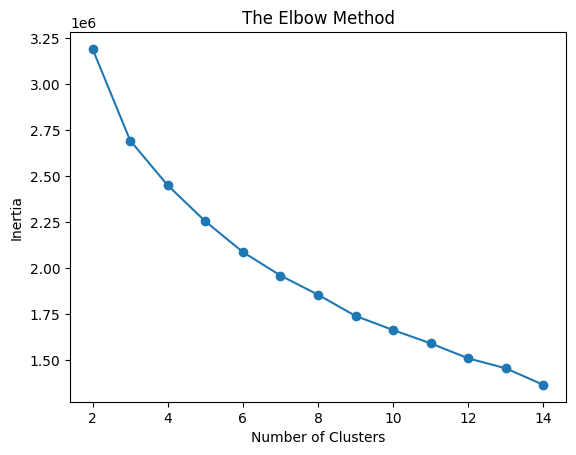

In [ ]:
inertia = []

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()].fillna(0)
column_names = g.columns
scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)
normalized_df = pd.DataFrame(normalized_data, columns=column_names)
transposed_df = normalized_df.transpose()

for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(transposed_df)  # หรือ df.T
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

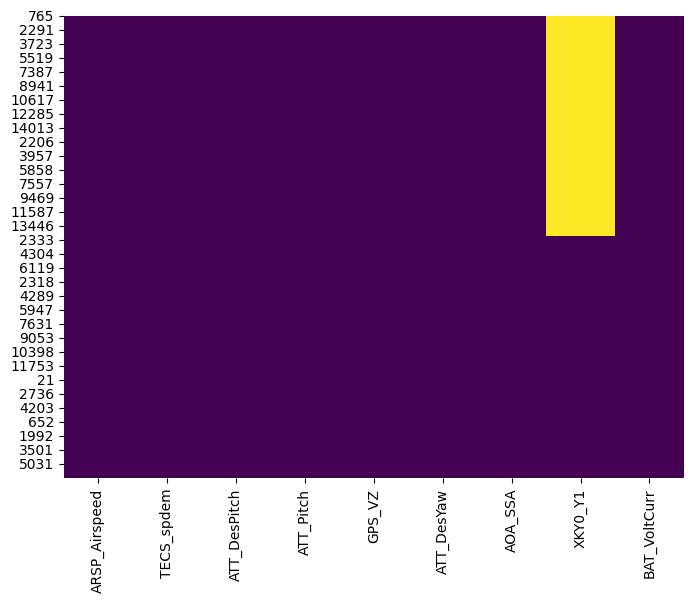

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/no_climb+direct_phase.csv"
df = pd.read_csv(filename,index_col=0)
selected_columns = [col for key, values in noclimb_direct.items() for col in values]
selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

plt.figure(figsize=(8, 6))
sns.heatmap(result_df.isnull(), cmap='viridis', cbar=False)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
feature_names = tuple(X.columns)


<ipython-input-39-5d634dbd1792>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestClassifier as rfc
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


sbs = SFS(#knn(n_neighbors=3),
           #rfc(n_jobs=8),
          # MLPRegressor(hidden_layer_sizes=(10, ), activation='relu', random_state=42),
           LinearRegression(),
          # SVR(gamma='scale'),
           k_features='best',
           forward=False,
           floating=False,
           verbose=2,
           scoring = 'neg_mean_absolute_error',  # sklearn regressors
          #  scoring='accuracy',  # sklearn classifiers
           cv=3)
sbs = sbs.fit(X_scaled, y)


[2023-12-27 20:39:32] Features: 7/1 -- score: -132.93758977424338
[2023-12-27 20:39:33] Features: 6/1 -- score: -124.7163574793092
[2023-12-27 20:39:33] Features: 5/1 -- score: -125.5787218705121
[2023-12-27 20:39:34] Features: 4/1 -- score: -125.2260147794425
[2023-12-27 20:39:34] Features: 3/1 -- score: -126.52620406986385
[2023-12-27 20:39:34] Features: 2/1 -- score: -128.283721130291
[2023-12-27 20:39:34] Features: 1/1 -- score: -137.45619583876405

In [ ]:
df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df

,feature_idx,avg_score
8,"(0, 1, 2, 3, 4, 5, 6, 7)",-140.838014
7,"(0, 1, 2, 3, 4, 6, 7)",-132.93759
6,"(1, 2, 3, 4, 6, 7)",-124.716357
5,"(1, 2, 4, 6, 7)",-125.578722
4,"(1, 2, 6, 7)",-125.226015
3,"(1, 2, 7)",-126.526204
2,"(1, 2)",-128.283721
1,"(2,)",-137.456196


In [ ]:
sbs.subsets_


{8: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7),
  'cv_scores': array([-110.6225271 , -141.13244374, -170.75907169]),
  'avg_score': -140.8380141757012,
  'feature_names': ('ARSP_Airspeed',
   'TECS_spdem',
   'ATT_DesPitch',
   'ATT_Pitch',
   'GPS_VZ',
   'ATT_DesYaw',
   'AOA_SSA',
   'XKY0_Y1')},
 7: {'feature_idx': (0, 1, 2, 3, 4, 6, 7),
  'cv_scores': array([-114.46515653, -147.73134095, -136.61627184]),
  'avg_score': -132.93758977424338,
  'feature_names': ('ARSP_Airspeed',
   'TECS_spdem',
   'ATT_DesPitch',
   'ATT_Pitch',
   'GPS_VZ',
   'AOA_SSA',
   'XKY0_Y1')},
 6: {'feature_idx': (1, 2, 3, 4, 6, 7),
  'cv_scores': array([-113.22508048, -144.05625176, -116.86774021]),
  'avg_score': -124.7163574793092,
  'feature_names': ('TECS_spdem',
   'ATT_DesPitch',
   'ATT_Pitch',
   'GPS_VZ',
   'AOA_SSA',
   'XKY0_Y1')},
 5: {'feature_idx': (1, 2, 4, 6, 7),
  'cv_scores': array([-113.89851903, -145.94740782, -116.89023876]),
  'avg_score': -125.5787218705121,
  'feature_names': ('TEC

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection

efs = ExhaustiveFeatureSelector(
           #knn(n_neighbors=3),
           #rfc(n_jobs=8),
           LinearRegression(),
          # max_features=len(X.columns),
           max_features=3,
          scoring='neg_mean_absolute_error',  # ใช้ neg_mean_absolute_error
          cv=3,
          n_jobs=-1)

efs = efs.fit(X_scaled, y)


Features: 92/92

In [ ]:
efs.best_feature_names_


('TECS_spdem', 'ATT_DesPitch', 'XKY0_Y1')

In [ ]:
f = pd.DataFrame.from_dict(efs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df

,feature_idx,avg_score
8,"(0, 1, 2, 3, 4, 5, 6, 7)",-140.838014
7,"(0, 1, 2, 3, 4, 6, 7)",-132.93759
6,"(1, 2, 3, 4, 6, 7)",-124.716357
5,"(1, 2, 4, 6, 7)",-125.578722
4,"(1, 2, 6, 7)",-125.226015
3,"(1, 2, 7)",-126.526204
2,"(1, 2)",-128.283721
1,"(2,)",-137.456196


# noclimb_turn

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/no_climb+turn_phase.csv"

# print(filename)
all_parameter_df = pd.read_csv(filename,index_col=0)
all_parameter_df = all_parameter_df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)

In [ ]:
df = all_parameter_df
df.fillna(0, inplace=True)
df = df.loc[:, (df != 0).any(axis=0)] #ลบทุก column ที่ทุก row = 0

df_corr = df.copy()
correlation_all_parameter = df_corr.corr()

correlation_with_powr = correlation_all_parameter.loc[correlation_all_parameter.index != 'BAT_VoltCurr', 'BAT_VoltCurr'].to_frame()  #ในข้อมูลพี่ริว คือ 21
correlation_with_powr['Abs_Corr'] = correlation_with_powr["BAT_VoltCurr"].abs()

sorted_correlation_with_powr = correlation_with_powr.sort_values(by='Abs_Corr', ascending=False).copy()
sorted_correlation_with_powr.drop('Abs_Corr',axis = 1 ,inplace = True)
sorted_correlation_with_rank = sorted_correlation_with_powr.iloc[:100].copy()
sorted_correlation_with_rank.loc[:, 'rank'] = range(1, 101)
sorted_correlation_with_rank.drop('BAT_VoltCurr',axis = 1 ,inplace = True)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()]

column_names = g.columns

scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)

normalized_df = pd.DataFrame(normalized_data, columns=column_names)

transposed_df = normalized_df.transpose()

kmeans = KMeans(n_clusters=6)

transposed_df['Cluster'] = kmeans.fit_predict(transposed_df)

for cluster, data in transposed_df.groupby('Cluster'):
    print(f"Cluster {cluster}:\n{data.index.tolist()}\n")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
['XKF1_dPD', 'XKF1_VD', 'GPS_VZ', 'XKF6_dPD', 'NK11_dPD', 'RCIN_C2', 'NK11_VD', 'XKF6_VD']

Cluster 1:
['ATT_DesPitch', 'CTUN_NavPitch', 'XKF1_Pitch', 'ATT_Pitch', 'CTUN_Pitch', 'AHR2_Pitch', 'BARO_CRt', 'NK11_Pitch', 'XKF6_Pitch', 'TECS_dh', 'BAR2_CRt']

Cluster 2:
['BAT_Curr', 'RCOU_C14', 'RCOU_C13', 'AETR_Thr', 'RCOU_C9', 'TECS_th', 'IMU_AccX', 'TEC2_PErr', 'TECS_ith', 'TECS_dsp', 'PSCD_AD', 'XKF3_IPD', 'TECS_dhdem', 'PSCD_DAD', 'XKF4_SM', 'PSCN_TVN', 'PSCN_VN', 'PSCN_DVN', 'RCIN_C7', 'PSCN_DAN', 'AHR2_Q3', 'RATE_YOut', 'CAM_Roll', 'NTUN_AltErr', 'RATE_RDes', 'QTUN_CRt', 'XKY1_IVN2', 'POWR_VServo', 'XKF8_IPD', 'PSCN_AN', 'AOA_AOA', 'XKY1_IVN3', 'NTUN_AspdE', 'XKY0_W1', 'TECS_iph']

Cluster 3:
['TEC2_LF', 'PIDP_Tar', 'AETR_Elev', 'CTUN_NavRoll', 'ATT_DesRoll', 'ATT_Roll', 'XKF1_Roll', 'CTUN_Roll', 'AHR2_Roll', 'TECS_ph', 'IMU_GyrZ', 'IMU_GyrY', 'PIDP_Act', 'PIDP_P']

Cluster 4:
['CTUN_ThO', 'CTUN_ThD', 'PIDP_FF', 'XKF1_PN', 'PIDP_Err', 'XKF2_AY', 'XKY0_W0', 'CTRL_RMSYaw', 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

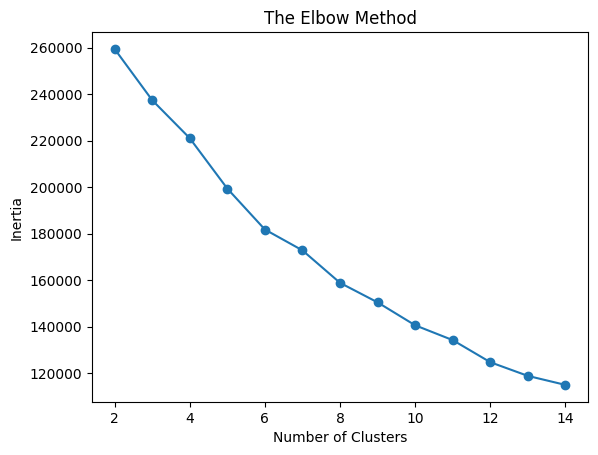

In [ ]:
inertia = []

g = all_parameter_df[sorted_correlation_with_rank.index.tolist()].fillna(0)
column_names = g.columns
scaler = StandardScaler()
normalized_data = scaler.fit_transform(g)
normalized_df = pd.DataFrame(normalized_data, columns=column_names)
transposed_df = normalized_df.transpose()

for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(transposed_df)  # หรือ df.T
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

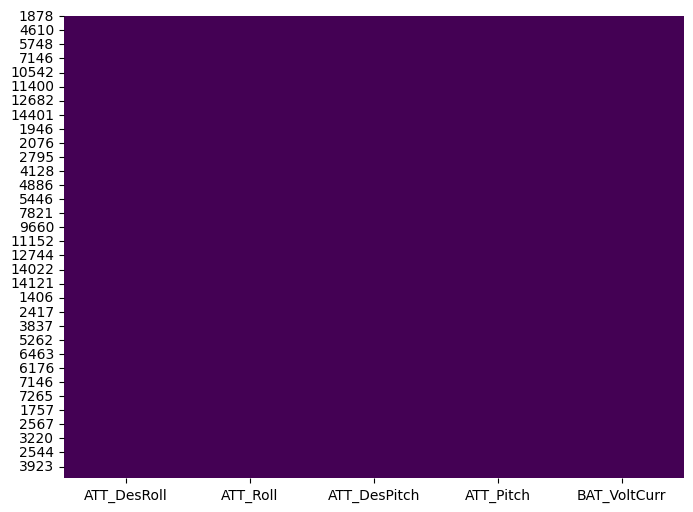

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/no_climb+turn_phase.csv"
df = pd.read_csv(filename,index_col=0)
selected_columns = [col for key, values in noclimb_turn.items() for col in values]
selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

plt.figure(figsize=(8, 6))
sns.heatmap(result_df.isnull(), cmap='viridis', cbar=False)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
feature_names = tuple(X.columns)


<ipython-input-28-5d634dbd1792>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestClassifier as rfc
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


sbs = SFS(#knn(n_neighbors=3),
           #rfc(n_jobs=8),
          # MLPRegressor(hidden_layer_sizes=(10, ), activation='relu', random_state=42),
           LinearRegression(),
          # SVR(gamma='scale'),
           k_features='best',
           forward=False,
           floating=False,
           verbose=2,
           scoring = 'neg_mean_absolute_error',  # sklearn regressors
          #  scoring='accuracy',  # sklearn classifiers
           cv=3)
sbs = sbs.fit(X_scaled, y)


[2024-01-03 15:58:19] Features: 3/1 -- score: -141.78159327462996
[2024-01-03 15:58:19] Features: 2/1 -- score: -142.3148868720787
[2024-01-03 15:58:19] Features: 1/1 -- score: -141.47349924748457

In [ ]:
df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df

,feature_idx,avg_score
4,"(0, 1, 2, 3)",-142.255864
3,"(0, 1, 2)",-141.781593
2,"(1, 2)",-142.314887
1,"(2,)",-141.473499


In [ ]:
sbs.subsets_


{4: {'feature_idx': (0, 1, 2, 3),
  'cv_scores': array([-133.91584459, -149.56876153, -143.28298593]),
  'avg_score': -142.25586401784594,
  'feature_names': ('ATT_DesRoll', 'ATT_Roll', 'ATT_DesPitch', 'ATT_Pitch')},
 3: {'feature_idx': (0, 1, 2),
  'cv_scores': array([-132.98255083, -149.64063579, -142.7215932 ]),
  'avg_score': -141.78159327462996,
  'feature_names': ('ATT_DesRoll', 'ATT_Roll', 'ATT_DesPitch')},
 2: {'feature_idx': (1, 2),
  'cv_scores': array([-134.11302229, -147.65018139, -145.18145693]),
  'avg_score': -142.3148868720787,
  'feature_names': ('ATT_Roll', 'ATT_DesPitch')},
 1: {'feature_idx': (2,),
  'cv_scores': array([-134.59646947, -143.18159709, -146.64243118]),
  'avg_score': -141.47349924748457,
  'feature_names': ('ATT_DesPitch',)}}

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection

efs = ExhaustiveFeatureSelector(
           #knn(n_neighbors=3),
           #rfc(n_jobs=8),
           LinearRegression(),
          # max_features=len(X.columns),
           max_features=2,
          scoring='neg_mean_absolute_error',  # ใช้ neg_mean_absolute_error
          cv=3,
          n_jobs=-1)

efs = efs.fit(X_scaled, y)


Features: 10/10

In [ ]:
efs.best_feature_names_


('TECS_spdem', 'ATT_DesPitch', 'XKY0_Y1')

In [ ]:
f = pd.DataFrame.from_dict(efs.get_metric_dict()).T
df = df[["feature_idx","avg_score"]]
df

,feature_idx,avg_score
8,"(0, 1, 2, 3, 4, 5, 6, 7)",-140.838014
7,"(0, 1, 2, 3, 4, 6, 7)",-132.93759
6,"(1, 2, 3, 4, 6, 7)",-124.716357
5,"(1, 2, 4, 6, 7)",-125.578722
4,"(1, 2, 6, 7)",-125.226015
3,"(1, 2, 7)",-126.526204
2,"(1, 2)",-128.283721
1,"(2,)",-137.456196


# model climb_direct

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/climb+direct_phase.csv"
df = pd.read_csv(filename,index_col=0)
selected_columns = ['CTUN_SAs', 'ATT_DesPitch']
selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
feature_names = tuple(X.columns)

<ipython-input-118-bb28f24a04ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

models = []
models.append(('LR', LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(10,))))


In [ ]:
from sklearn.model_selection import KFold, cross_val_score


results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)  # Use KFold instead of StratifiedKFold
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')  # Use regression metric (e.g., neg_mean_squared_error)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, -cv_results.mean(), cv_results.std()))  # Note: negative of mean squared error is used


LR: 202.107003 (5.216170)
DT: 97.082917 (2.480685)
RF: 103.421688 (3.229807)
KNN: 128.644947 (2.923832)
SVR: 181.344810 (5.452186)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLP: 187.419409 (7.062896)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


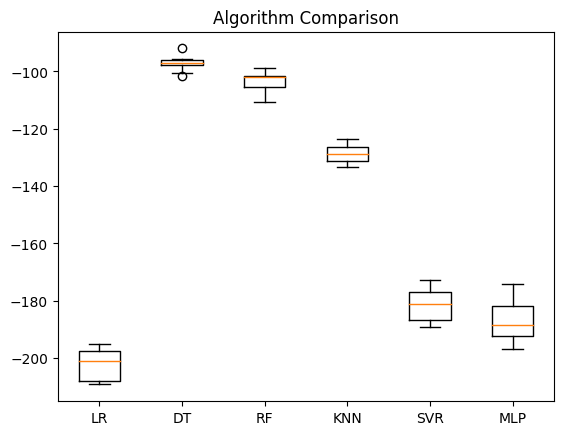

In [ ]:
from matplotlib import pyplot

pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [ ]:
model_phase_CD = DecisionTreeRegressor()
model_phase_CD.fit(X, y)


DecisionTreeRegressor()

# model climb_turn

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/climb+turn_phase.csv"
df = pd.read_csv(filename,index_col=0)
# selected_columns = ['IMU_AccX', 'AHR2_Pitch']
selected_columns = ['TECS_dsp', 'ATT_Pitch']

selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
feature_names = tuple(X.columns)

<ipython-input-96-818f86823b35>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

models = []
models.append(('LR', LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(10,))))


In [ ]:
from sklearn.model_selection import KFold, cross_val_score


results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)  # Use KFold instead of StratifiedKFold
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')  # Use regression metric (e.g., neg_mean_squared_error)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, -cv_results.mean(), cv_results.std()))  # Note: negative of mean squared error is used


LR: 117.432228 (5.604889)
DT: 84.929929 (4.816156)
RF: 75.818733 (3.697888)
KNN: 93.201952 (5.971340)
SVR: 260.187711 (5.866292)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLP: 463.250145 (83.457249)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


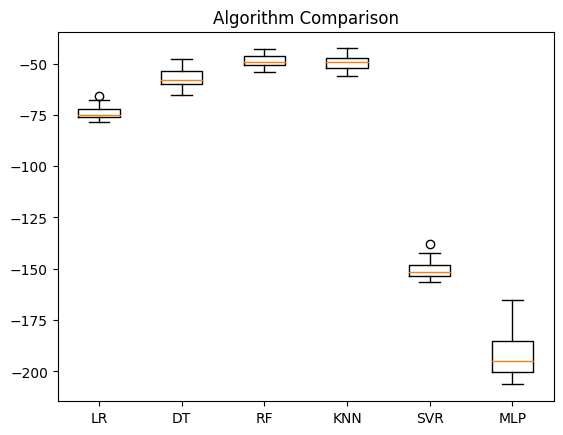

In [ ]:
from matplotlib import pyplot

pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [ ]:
model_phase_CT = DecisionTreeRegressor()
model_phase_CT.fit(X, y)


DecisionTreeRegressor()

# model noclimb_direct

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/no_climb+direct_phase.csv"
df = pd.read_csv(filename,index_col=0)
selected_columns = ['TECS_spdem', 'ATT_DesPitch', 'XKY0_Y1']

selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
feature_names = tuple(X.columns)

<ipython-input-107-786679d2d6f0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

models = []
models.append(('LR', LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(10,))))


In [ ]:
from sklearn.model_selection import KFold, cross_val_score


results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)  # Use KFold instead of StratifiedKFold
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')  # Use regression metric (e.g., neg_mean_squared_error)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, -cv_results.mean(), cv_results.std()))  # Note: negative of mean squared error is used


LR: 121.528119 (1.848178)
DT: 64.475999 (1.274090)
RF: 65.034757 (1.308218)
KNN: 81.015034 (1.703085)
SVR: 122.749799 (1.845447)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLP: 123.747018 (1.399500)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


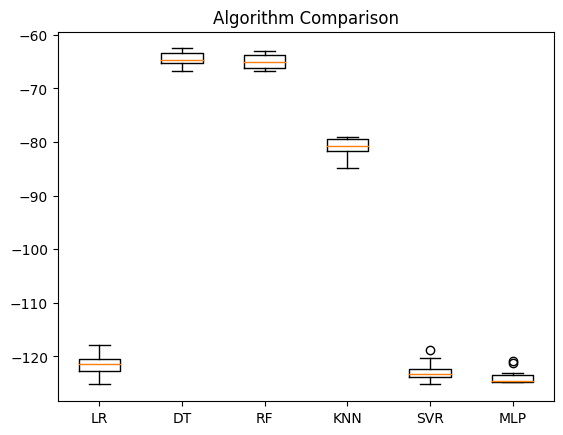

In [ ]:
from matplotlib import pyplot

pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [ ]:
model_phase_NCD = DecisionTreeRegressor()
model_phase_NCD.fit(X, y)


DecisionTreeRegressor()

# model noclimb_turn

In [ ]:
filename = "drive/My Drive/Senior Project/Complete_combine/filter_mode_to_phase/no_climb+turn_phase.csv"
df = pd.read_csv(filename,index_col=0)
selected_columns = ['ATT_Roll', 'ATT_DesPitch']

selected_columns.append('BAT_VoltCurr')
result_df = df[selected_columns]

result_df.fillna(0,inplace=True)
X = result_df.iloc[:,0:-1]
y = result_df.iloc[:,-1]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
feature_names = tuple(X.columns)

<ipython-input-42-1b308dbff122>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.fillna(0,inplace=True)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

models = []
models.append(('LR', LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(10,))))


In [ ]:
from sklearn.model_selection import KFold, cross_val_score


results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)  # Use KFold instead of StratifiedKFold
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')  # Use regression metric (e.g., neg_mean_squared_error)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, -cv_results.mean(), cv_results.std()))  # Note: negative of mean squared error is used


LR: 130.859413 (7.863784)
DT: 108.463804 (8.539796)
RF: 103.111432 (5.006395)
KNN: 122.298994 (5.021779)
SVR: 142.028165 (7.864985)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

MLP: 169.012284 (8.714875)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


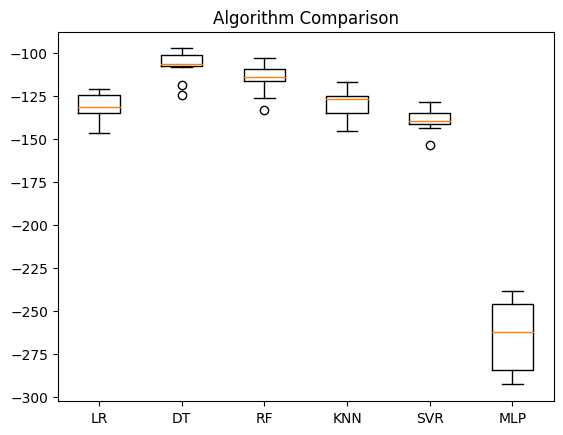

In [ ]:
from matplotlib import pyplot

pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [ ]:
model_phase_NCT = RandomForestRegressor()
model_phase_NCT.fit(X, y)


RandomForestRegressor()

# total

In [ ]:
files = glob.glob(f"drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/*.csv")

phase_df = pd.DataFrame()


for file in files:
    df = pd.read_csv(file)
    print(df.shape)

(14639, 560)
(14766, 573)
(6819, 636)
(13165, 644)
(5116, 644)
(6417, 644)


In [ ]:
files = glob.glob(f"drive/My Drive/Senior Project/Complete_combine/2_to_filter_mode/*.csv")

df_filter_mode = pd.DataFrame()


for file in files:
    df = pd.read_csv(file)
    #for 4.1.5
    columns_to_remove = df.filter(regex=r'\[.*[1-9].*\]').columns #ลบที่ไม่ใช่ [0]
    df.drop(columns=columns_to_remove, inplace=True)

    df.rename(columns=lambda x: x.replace(r'[0]', ''), inplace=True)

    #for 4.0.8
    columns_to_remove = df.filter(regex=r'^IMU(\d+)').columns
    df.drop(columns=columns_to_remove, inplace=True)
    df.rename(columns=lambda x: re.sub(r'^NKF(\d+)', r'XKF\1', x), inplace=True)

    filtered_df = df.drop(['TimeUS','BAT_EnrgDiff'],errors='ignore', axis = 1)
    df_filter_mode = pd.concat([df_filter_mode, filtered_df])


In [ ]:
print("df_climb_direct shape:", df_climb_direct.shape)
print("df_climb_turn shape:", df_climb_turn.shape)
print("df_no_climb_direct shape:", df_no_climb_direct.shape)
print("df_no_climb_turn shape:", df_no_climb_turn.shape)

df_climb_direct shape: (11170, 3)
df_climb_turn shape: (2299, 3)
df_no_climb_direct shape: (44203, 4)
df_no_climb_turn shape: (3250, 3)


In [ ]:
from sklearn.metrics import mean_squared_error

#df ต้อง filter mode แล้ว
df = df_filter_mode.fillna(0)
actual_energy = df['BAT_VoltCurr'].sum()

condition_climb_direct = (df['ATT_Roll'] <= 10) & (df['TECS_dh'] > 1)
condition_climb_turn = (df['ATT_Roll'] > 10) & (df['TECS_dh'] > 1)
condition_no_climb_direct = (df['ATT_Roll'] <= 10) & (df['TECS_dh'] < 1)
condition_no_climb_turn = (df['ATT_Roll'] > 10) & (df['TECS_dh'] < 1)

df_climb_direct = df[condition_climb_direct].copy()
df_climb_turn = df[condition_climb_turn].copy()
df_no_climb_direct = df[condition_no_climb_direct].copy()
df_no_climb_turn = df[condition_no_climb_turn].copy()


column_climb_direct = ['CTUN_SAs', 'ATT_DesPitch', 'BAT_VoltCurr']
model_phase_CD = DecisionTreeRegressor(random_state=42)
df_climb_direct = df_climb_direct[column_climb_direct].copy()
X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(df_climb_direct.iloc[:,0:-1], df_climb_direct.iloc[:,-1], test_size=0.20, random_state=1)
model_phase_CD.fit(X_train_CD, y_train_CD)

column_climb_turn = ['TECS_dsp', 'ATT_Pitch' , 'BAT_VoltCurr']
model_phase_CT = RandomForestRegressor(random_state=42)
df_climb_turn = df_climb_turn[column_climb_turn].copy()
X_train_CT, X_test_CT, y_train_CT, y_test_CT = train_test_split(df_climb_turn.iloc[:,0:-1], df_climb_turn.iloc[:,-1], test_size=0.20, random_state=1)
model_phase_CT.fit(X_train_CT, y_train_CT)

column_no_climb_direct = ['TECS_spdem', 'ATT_DesPitch', 'XKY0_Y1' , 'BAT_VoltCurr']
model_phase_NCD = DecisionTreeRegressor(random_state=42)
df_no_climb_direct = df_no_climb_direct[column_no_climb_direct].copy()
X_train_NCD, X_test_NCD, y_train_NCD, y_test_NCD = train_test_split(df_no_climb_direct.iloc[:,0:-1], df_no_climb_direct.iloc[:,-1], test_size=0.20, random_state=1)
model_phase_NCD.fit(X_train_NCD, y_train_NCD)

column_no_climb_turn = ['ATT_Roll', 'ATT_DesPitch' , 'BAT_VoltCurr']
model_phase_NCT = RandomForestRegressor(random_state=42)
df_no_climb_turn = df_no_climb_turn[column_no_climb_turn].copy()
X_train_NCT, X_test_NCT, y_train_NCT, y_test_NCT = train_test_split(df_no_climb_turn.iloc[:,0:-1], df_no_climb_turn.iloc[:,-1], test_size=0.20, random_state=1)
model_phase_NCT.fit(X_train_NCT, y_train_NCT)

predictions_climb_direct = model_phase_CD.predict(X_test_CD)
predictions_climb_turn = model_phase_CT.predict(X_test_CT)
predictions_no_climb_direct = model_phase_NCD.predict(X_test_NCD)
predictions_no_climb_turn = model_phase_NCT.predict(X_test_NCT)

# predict_energy = predictions_climb_direct + predictions_climb_turn + predictions_no_climb_direct + predictions_no_climb_turn

# error = actual_energy - predict_energy
# percentage_error = (abs(error) / actual_energy) * 100
# print(error , percentage_error)

error_CD = mean_squared_error(y_test_CD, predictions_climb_direct ,squared=False)
error_CT = mean_squared_error(y_test_CT, predictions_climb_turn ,squared=False)
error_NCD = mean_squared_error(y_test_NCD, predictions_no_climb_direct ,squared=False)
error_NCT = mean_squared_error(y_test_NCT, predictions_no_climb_turn ,squared=False)

#RMSE
print(error_CD)
print(error_CT)
print(error_NCD)
print(error_NCT)


182.68945852678044
113.75309011939072
111.33602055996505
169.02054946119907


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


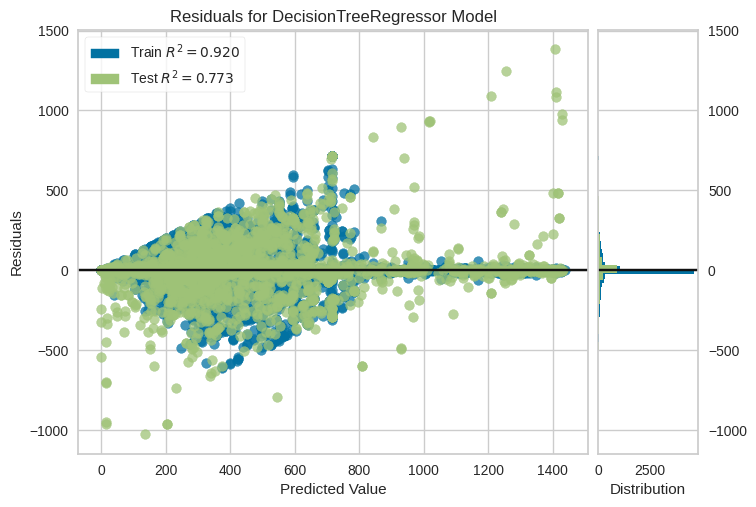

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


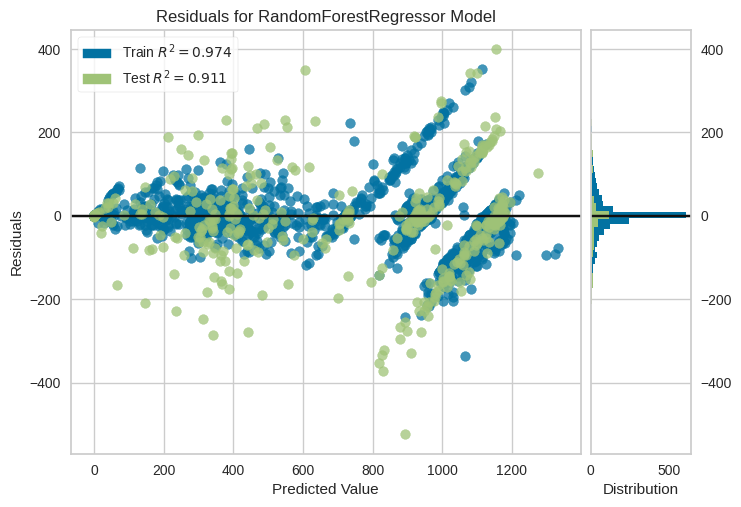

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


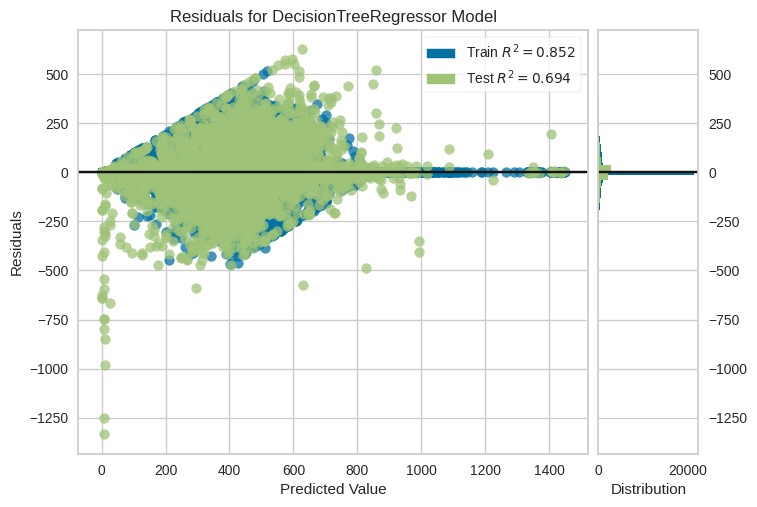

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


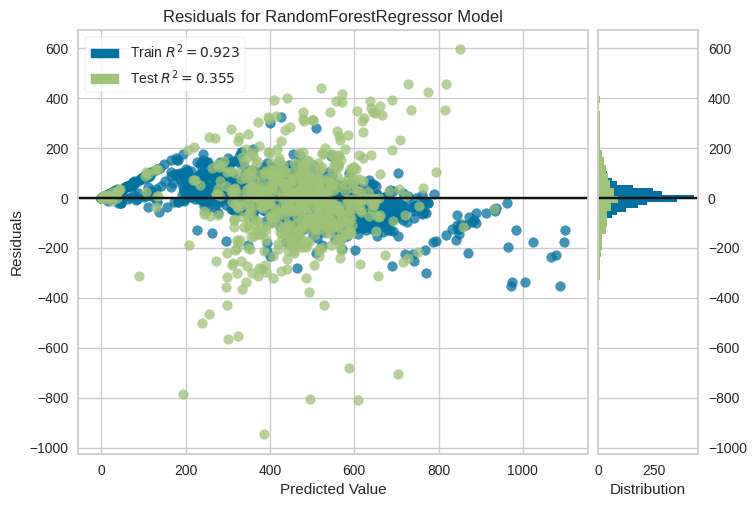

In [ ]:

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import residuals_plot

viz = residuals_plot(model_phase_CD, X_train_CD, y_train_CD, X_test_CD, y_test_CD)
viz = residuals_plot(model_phase_CT, X_train_CT, y_train_CT, X_test_CT, y_test_CT)
viz = residuals_plot(model_phase_NCD, X_train_NCD, y_train_NCD, X_test_NCD, y_test_NCD)
viz = residuals_plot(model_phase_NCT, X_train_NCT, y_train_NCT, X_test_NCT, y_test_NCT)


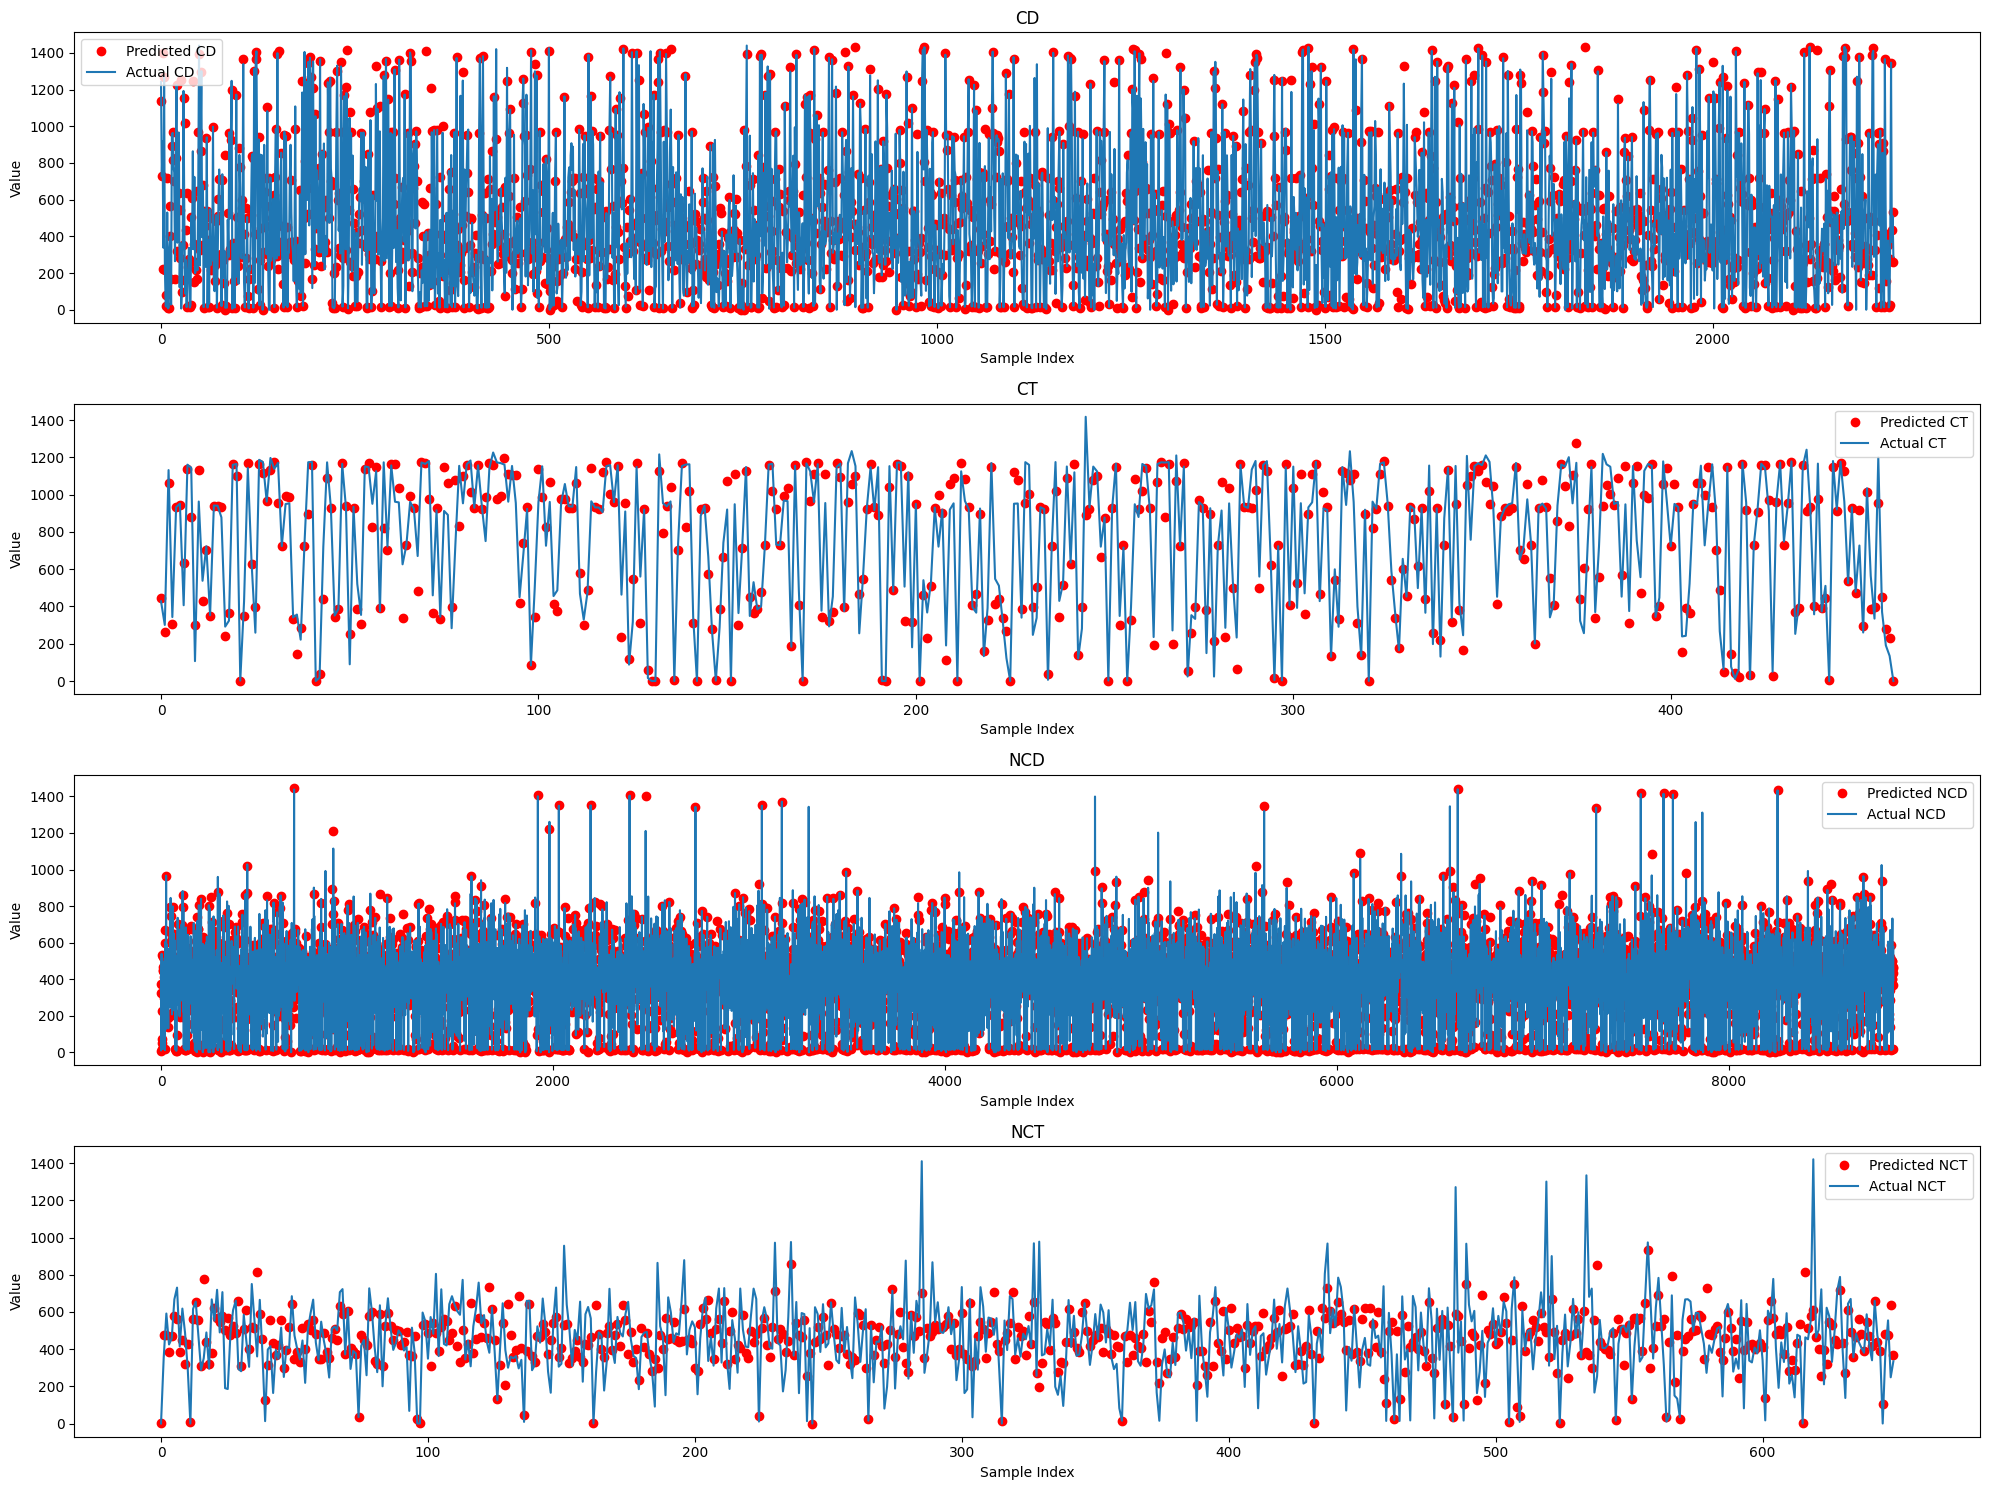

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

for i, (predictions, y_test, label) in enumerate(zip(
        [predictions_CD, predictions_CT, predictions_NCD, predictions_NCT],
        [y_test_CD, y_test_CT, y_test_NCD, y_test_NCT],
        ['CD', 'CT', 'NCD', 'NCT']
    )):

    plt.subplot(4, 1, i+1)

    plt.plot(predictions, 'o',label=f'Predicted {label}' ,color='red')
    plt.plot(y_test.to_numpy(), label=f'Actual {label}')

    plt.title(f'{label}')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()

plt.show()


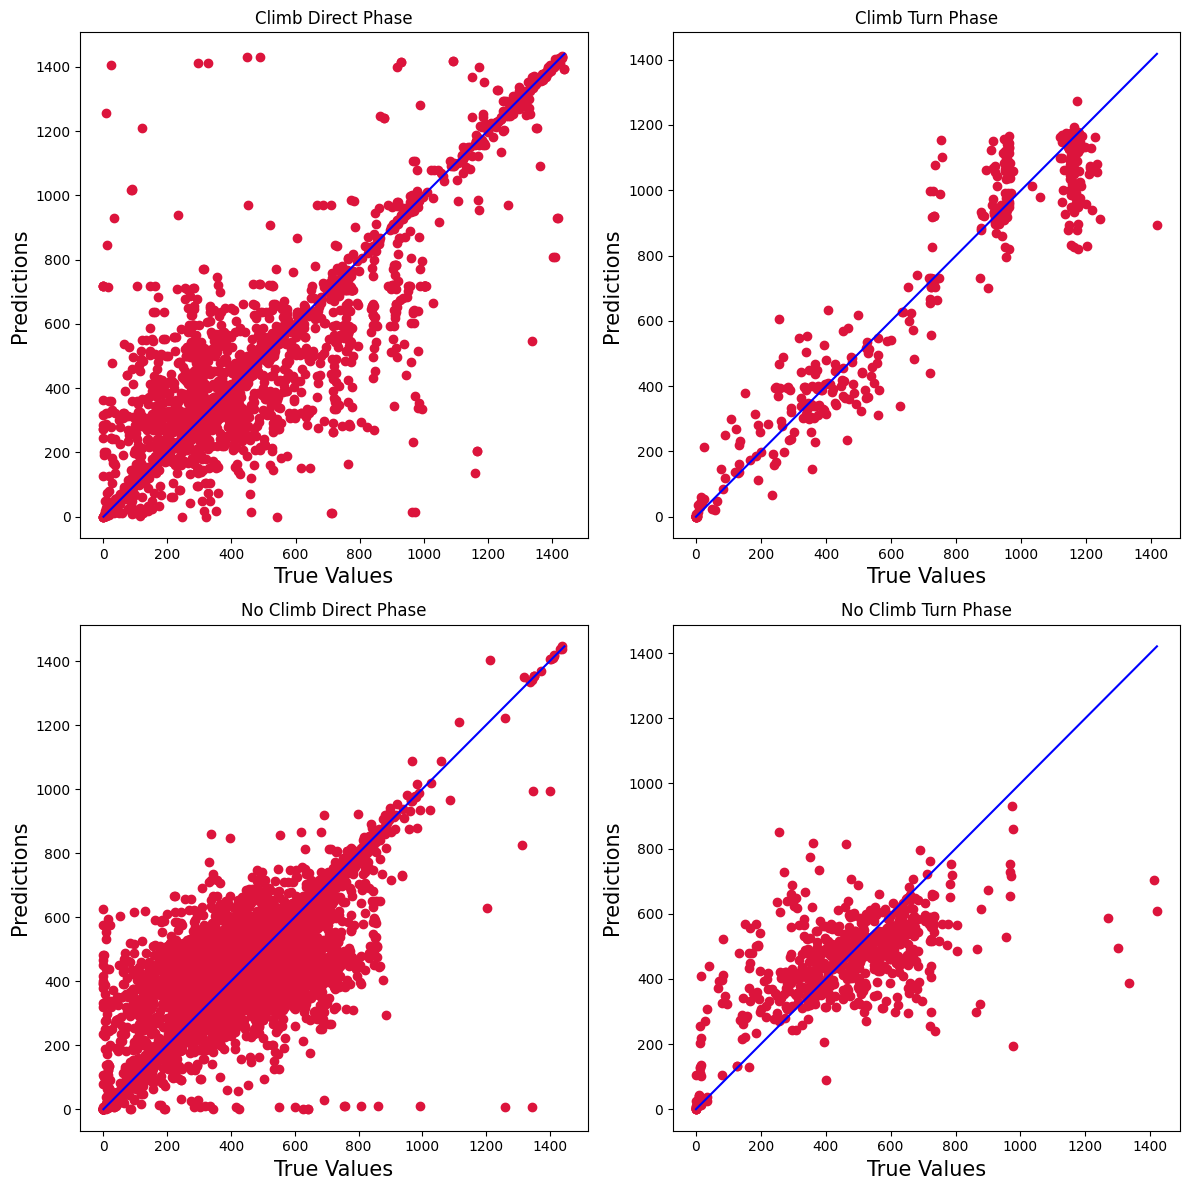

In [ ]:
import matplotlib.pyplot as plt

def plot(actual, predict, ax, title=''):
    ax.scatter(actual, predict, c='crimson')
    p1 = max(max(predict), max(actual))
    p2 = min(min(predict), min(actual))
    ax.plot([p1, p2], [p1, p2], 'b-')
    ax.set_xlabel('True Values', fontsize=15)
    ax.set_ylabel('Predictions', fontsize=15)
    ax.set_title(title)
    ax.axis('equal')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

plot(y_test_CD, predictions_climb_direct, axes[0, 0], 'Climb Direct Phase')
plot(y_test_CT, predictions_climb_turn, axes[0, 1], 'Climb Turn Phase')
plot(y_test_NCD, predictions_no_climb_direct, axes[1, 0], 'No Climb Direct Phase')
plot(y_test_NCT, predictions_no_climb_turn, axes[1, 1], 'No Climb Turn Phase')

plt.tight_layout()
plt.show()


In [ ]:
actual_energy

26058918.647125207

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd


# Split the data for each phase
# ...

# Train each model on its corresponding data
# ...

# Predictions for each phase
predictions_CD = model_phase_CD.predict(X_test_CD)
predictions_CT = model_phase_CT.predict(X_test_CT)
predictions_NCD = model_phase_NCD.predict(X_test_NCD)
predictions_NCT = model_phase_NCT.predict(X_test_NCT)

# Create StackingRegressor
estimators = [
    ('model_phase_CD', model_phase_CD),
    ('model_phase_CT', model_phase_CT),
    ('model_phase_NCD', model_phase_NCD),
    ('model_phase_NCT', model_phase_NCT)
]

stacking_model = StackingRegressor(estimators=estimators, final_estimator=DecisionTreeRegressor(random_state=42))

# Fit StackingRegressor on the entire dataset
stacking_model.fit(df[['CTUN_SAs', 'ATT_DesPitch', 'BAT_VoltCurr', 'TECS_dsp', 'ATT_Pitch', 'XKY0_Y1', 'ATT_Roll']],
                   df['BAT_VoltCurr'])

# Make predictions using the StackingRegressor
total_predictions = stacking_model.predict(df[['CTUN_SAs', 'ATT_DesPitch', 'BAT_VoltCurr', 'TECS_dsp', 'ATT_Pitch', 'XKY0_Y1', 'ATT_Roll']])

# Calculate RMSE
error = mean_squared_error(df['BAT_VoltCurr'], total_predictions, squared=False)
print(error)


0.18060276177352766


In [ ]:
stacking_model

StackingRegressor(estimators=[('model_phase_CD',
                               DecisionTreeRegressor(random_state=42)),
                              ('model_phase_CT',
                               RandomForestRegressor(random_state=42)),
                              ('model_phase_NCD',
                               DecisionTreeRegressor(random_state=42)),
                              ('model_phase_NCT',
                               RandomForestRegressor(random_state=42))],
                  final_estimator=DecisionTreeRegressor(random_state=42))

In [ ]:
y_test_NCT.sum(), predictions_no_climb_turn.sum()

(296260.3118723784, 293186.5487840563)

In [167]:
df = df_filter_mode.fillna(0)
actual_energy = df['BAT_VoltCurr'].sum()

condition_climb_direct = (df['ATT_Roll'] <= 10) & (df['TECS_dh'] > 1)
condition_climb_turn = (df['ATT_Roll'] > 10) & (df['TECS_dh'] > 1)
condition_no_climb_direct = (df['ATT_Roll'] <= 10) & (df['TECS_dh'] < 1)
condition_no_climb_turn = (df['ATT_Roll'] > 10) & (df['TECS_dh'] < 1)

df_climb_direct = df[condition_climb_direct].copy()
df_climb_turn = df[condition_climb_turn].copy()
df_no_climb_direct = df[condition_no_climb_direct].copy()
df_no_climb_turn = df[condition_no_climb_turn].copy()

X_CD=df_climb_direct.drop('BAT_VoltCurr', axis=1)
y_CD=df_climb_direct['BAT_VoltCurr']
X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(X_CD, y_CD, test_size=0.20, random_state=1)

X_CT=df_climb_turn.drop('BAT_VoltCurr', axis=1)
y_CT=df_climb_turn['BAT_VoltCurr']
X_train_CT, X_test_CT, y_train_CT, y_test_CT = train_test_split(X_CT, y_CT, test_size=0.20, random_state=1)

X_NCD=df_no_climb_direct.drop('BAT_VoltCurr', axis=1)
y_NCD=df_no_climb_direct['BAT_VoltCurr']
X_train_NCD, X_test_NCD, y_train_NCD, y_test_NCD = train_test_split(X_NCD, y_NCD, test_size=0.20, random_state=1)

X_NCT=df_no_climb_turn.drop('BAT_VoltCurr', axis=1)
y_NCT=df_no_climb_turn['BAT_VoltCurr']
X_train_NCT, X_test_NCT, y_train_NCT, y_test_NCT = train_test_split(X_NCT, y_NCT, test_size=0.20, random_state=1)



In [168]:
total1 = pd.concat([X_test_CD, y_test_CD],axis = 1)
total2 = pd.concat([X_test_CT, y_test_CT],axis = 1)
total3 = pd.concat([X_test_NCD, y_test_NCD],axis = 1)
total4 = pd.concat([X_test_NCT, y_test_NCT],axis = 1)
total = pd.concat([total1, total2 , total3, total4],axis = 0)

In [ ]:
total

,IMU_GyrX,IMU_GyrY,IMU_GyrZ,IMU_AccX,IMU_AccY,IMU_AccZ,IMU_EG,IMU_EA,IMU_T,IMU_GHz,...,QTUN_Sscl,PSCD_TPD,PSCD_PD,PSCD_DVD,PSCD_TVD,PSCD_VD,PSCD_DAD,PSCD_TAD,PSCD_AD,BAT_VoltCurr
841,0.007324,-0.028766,0.030965,1.689741,-0.102702,-8.823708,0,0,53.32085,8030,...,0.0,-67.686274,-69.769104,-0.559097,1.523730,-2.756982,0.034359,21.418980,0.493740,1241.357357
878,-0.099003,-0.105450,-0.001866,0.806220,-0.021464,-9.507814,0,0,64.14101,8027,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,727.719923
479,-0.009028,0.044964,0.076328,0.927184,-0.173810,-9.689764,0,0,53.24512,8030,...,0.0,-59.619203,-62.006500,-0.582862,1.804434,-3.103043,0.036519,24.556279,0.589926,916.548404
6123,0.120059,-0.102886,0.034411,-0.131340,-0.047169,-5.976741,0,0,48.42837,7962,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,338.369743
838,-0.007972,0.012845,0.036921,1.788028,-0.232672,-9.536491,0,0,53.32311,8030,...,0.0,-67.619420,-69.704773,-0.559293,1.526056,-2.759850,0.034377,21.444980,0.494537,1270.651991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14485,0.045478,-0.165476,-0.029844,-1.411551,-0.457901,-10.667230,0,0,46.93239,8031,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3904,-0.099326,-0.031925,0.125771,0.165214,0.024438,-9.795487,0,0,44.90547,8032,...,0.0,-50.652784,-50.742077,-0.048667,0.040626,-0.008844,0.216549,0.459655,0.541113,381.877003
7186,0.016293,0.146370,0.173134,0.643781,-0.080113,-15.794900,0,0,44.58011,8032,...,0.0,-82.995144,-84.185427,-0.896790,0.280511,-1.369634,0.557822,8.860786,0.756535,554.463878
11038,0.183504,0.001058,-0.085414,-0.271508,-0.552789,-8.877269,0,0,48.40498,8031,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,248.503569


In [ ]:
class StackingModel:
    def __init__(self, model_CD, model_CT, model_NCD, model_NCT):
        self.model_CD = model_CD
        self.model_CT = model_CT
        self.model_NCD = model_NCD
        self.model_NCT = model_NCT

    def predict(self, data):
        predictions_CD= np.zeros((0, 0))
        predictions_CT= np.zeros((0, 0))
        predictions_NCD= np.zeros((0, 0))
        predictions_NCT = np.zeros((0, 0))

        condition_CD = (data['ATT_Roll'] <= 10) & (data['TECS_dh'] > 1)
        condition_CT = (data['ATT_Roll'] > 10) & (data['TECS_dh'] > 1)
        condition_NCD = (data['ATT_Roll'] <= 10) & (data['TECS_dh'] < 1)
        condition_NCT = (data['ATT_Roll'] > 10) & (data['TECS_dh'] < 1)

        if condition_CD.any():
            temp_CD = data[condition_CD]
            predictions_CD = self.model_CD.predict(temp_CD[['CTUN_SAs', 'ATT_DesPitch']])
            error_CD = mean_squared_error(temp_CD['BAT_VoltCurr'], predictions_CD, squared=False)
            print("Mean Squared Error for CD:", error_CD)

        if condition_CT.any():
            temp_CT = data[condition_CT]
            predictions_CT = self.model_CT.predict(temp_CT[['TECS_dsp', 'ATT_Pitch']])
            error_CT = mean_squared_error(temp_CT['BAT_VoltCurr'], predictions_CT, squared=False)
            print("Mean Squared Error for CT:", error_CT)

        if condition_NCD.any():
            temp_NCD = data[condition_NCD]
            predictions_NCD = self.model_NCD.predict(temp_NCD[['TECS_spdem', 'ATT_DesPitch', 'XKY0_Y1']])
            error_NCD = mean_squared_error(temp_NCD['BAT_VoltCurr'], predictions_NCD, squared=False)
            print("Mean Squared Error for NCD:", error_NCD)

        if condition_NCT.any():
            temp_NCT = data[condition_NCT]
            predictions_NCT = self.model_NCT.predict(temp_NCT[['ATT_Roll', 'ATT_DesPitch']])
            error_NCT = mean_squared_error(temp_NCT['BAT_VoltCurr'], predictions_NCT, squared=False)
            print("Mean Squared Error for NCT:", error_NCT)

        total_predictions = predictions_CD.sum() + predictions_CT.sum() + predictions_NCD.sum() + predictions_NCT.sum()
        return total_predictions


# สร้าง StackingModel ด้วยโมเดลย่อย 4 ตัว
stacking_model = StackingModel(model_phase_CD, model_phase_CT, model_phase_NCD, model_phase_NCT)

# ป้อนข้อมูลทดสอบ (df)
total_predictions = stacking_model.predict(total)
# total_predictions

Mean Squared Error for CD: 182.68945852678044
Mean Squared Error for CT: 113.75309011939072
Mean Squared Error for NCD: 111.33602055996505
Mean Squared Error for NCT: 169.02054946119907


In [175]:
class StackingModel:
    def __init__(self, model_CD, model_CT, model_NCD, model_NCT):
        self.model_CD = model_CD
        self.model_CT = model_CT
        self.model_NCD = model_NCD
        self.model_NCT = model_NCT

    def predict(self, data):
        total_predictions = 0
        predictions_CD= np.zeros((0, 0))
        predictions_CT= np.zeros((0, 0))
        predictions_NCD= np.zeros((0, 0))
        predictions_NCT = np.zeros((0, 0))

        condition_CD = (data['ATT_Roll'] <= 10) & (data['TECS_dh'] > 1)
        condition_CT = (data['ATT_Roll'] > 10) & (data['TECS_dh'] > 1)
        condition_NCD = (data['ATT_Roll'] <= 10) & (data['TECS_dh'] < 1)
        condition_NCT = (data['ATT_Roll'] > 10) & (data['TECS_dh'] < 1)

        if condition_CD.any():
            temp_CD = data[condition_CD]
            predictions_CD = self.model_CD.predict(temp_CD[['CTUN_SAs', 'ATT_DesPitch']])
            error_CD = mean_squared_error(temp_CD['BAT_VoltCurr'], predictions_CD, squared=False)
            print("Mean Squared Error for CD:", error_CD)

        if condition_CT.any():
            temp_CT = data[condition_CT]
            predictions_CT = self.model_CT.predict(temp_CT[['TECS_dsp', 'ATT_Pitch']])
            error_CT = mean_squared_error(temp_CT['BAT_VoltCurr'], predictions_CT, squared=False)
            print("Mean Squared Error for CT:", error_CT)

        if condition_NCD.any():
            temp_NCD = data[condition_NCD]
            predictions_NCD = self.model_NCD.predict(temp_NCD[['TECS_spdem', 'ATT_DesPitch', 'XKY0_Y1']])
            error_NCD = mean_squared_error(temp_NCD['BAT_VoltCurr'], predictions_NCD, squared=False)
            print("Mean Squared Error for NCD:", error_NCD)

        if condition_NCT.any():
            temp_NCT = data[condition_NCT]
            predictions_NCT = self.model_NCT.predict(temp_NCT[['ATT_Roll', 'ATT_DesPitch']])
            error_NCT = mean_squared_error(temp_NCT['BAT_VoltCurr'], predictions_NCT, squared=False)
            print("Mean Squared Error for NCT:", error_NCT)

        # x = temp_CD['BAT_VoltCurr'].sum() + temp_CT['BAT_VoltCurr'].sum() + temp_NCD['BAT_VoltCurr'].sum() + temp_NCT['BAT_VoltCurr'].sum()

        total_predictions = predictions_CD.sum() + predictions_CT.sum() + predictions_NCD.sum() + predictions_NCT.sum()
        return total_predictions


# สร้าง StackingModel ด้วยโมเดลย่อย 4 ตัว
stacking_model = StackingModel(model_phase_CD, model_phase_CT, model_phase_NCD, model_phase_NCT)

# ป้อนข้อมูลทดสอบ (df)
total_predictions  = stacking_model.predict(total)
# total_predictions
total_predictions

Mean Squared Error for CD: 182.68945852678044
Mean Squared Error for CT: 113.75309011939072
Mean Squared Error for NCD: 111.33602055996505
Mean Squared Error for NCT: 169.02054946119907


5224735.791918893

#sobol

In [ ]:
import sobol_seq
from sklearn.linear_model import LinearRegression
from SALib.analyze import sobol

models = [model_phase_CD, model_phase_CT, model_phase_NCD, model_phase_NCT]

N = 16384
X_sobol = sobol_seq.i4_sobol_generate(len(X_combined.columns), N)

# Calculate Sobol indices for each model
sobol_indices = []
for i, model in enumerate(models):
    # Define problem_combined for each model
    problem_combined = {
        'num_vars': len(model.feature_importances_),
        'names': X_combined.columns.tolist(),
        'bounds': [(X_combined.iloc[:, i].min(), X_combined.iloc[:, i].max()) for i in range(len(X_combined.columns))]
    }

    y_sobol = model.predict(X_sobol)
    Si = sobol.analyze(problem_combined, y_sobol)
    sobol_indices.append(Si)

# Calculate the average Sobol indices
average_sobol_indices = {}
for Si in sobol_indices:
    for var in Si:
        if var not in average_sobol_indices:
            average_sobol_indices[var] = 0
        average_sobol_indices[var] += Si[var]['ST']

# Normalize by the number of models
for var in average_sobol_indices:
    average_sobol_indices[var] /= len(models)

print(average_sobol_indices)


#shapley

In [178]:
!pip install SALib

import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00


In [ ]:
problem = {'num_vars': num_features, 'names': feature_names, 'bounds': bounds}
X_sobol = saltelli.sample(problem, N)

models = [RandomForestRegressor(), LinearRegression()]
sobol_indices_by_model = []

for model in models:
    model_outputs = []
    for condition, model_data in your_data_split_by_condition.items():
        X_train, X_test, y_train, y_test = train_test_split(model_data['X'], model_data['y'], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        output = model.predict(X_sobol)
        model_outputs.append(output)

    # รวม output จากทุกเงื่อนไข
    ensemble_output = np.mean(np.array(model_outputs), axis=0)

    # คำนวณ Sobol indices จาก input และ output ที่ได้จากโมเดล
    si = sobol.analyze(problem, ensemble_output)
    sobol_indices_by_model.append(si)

# แสดงผล Sobol indices สำหรับแต่ละโมเดล
for model, si in zip(models, sobol_indices_by_model):
    print(f"Sobol Indices for {model.__class__.__name__}:", si)


In [ ]:
from SALib.analyze import sobol as sobol_analyze
from SALib.test_functions import Ishigami
from SALib.sample import sobol
import shap
import sklearn
import pandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axis as ax
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


df = df.drop(columns=['TimeUS', 'Color_on_Path',"GPS_Lat","GPS_Lng","GPS_Alt"])
X = df.drop(columns=["AOA_SSA","NKF2_VWN","NKF2_VWE","Volt_x_Curr"]) #132
# X = df.drop(columns=["Volt_x_Curr"])
y = df["Volt_x_Curr"]

model = sklearn.linear_model.LinearRegression().fit(X, y)


problem = {
    'num_vars': 13,
    'names': X.columns.tolist(),
    'bounds': [(X.iloc[:, i].min(), X.iloc[:, i].max()) for i in range(len(X.columns))]
}

N = 16384 # number of samples
# Generate samples
X_sobol = sobol.sample(problem, N, calc_second_order=False)
y_sobol = model.predict(X_sobol)

# y_sobol = model.predict(X.iloc[:18000])
# print(len(y_sobol))

Si = sobol_analyze.analyze(problem, y_sobol, calc_second_order=False )
print(Si)

fig, ax = plt.subplots()
indices = Si['ST']
names = problem['names']
y_pos = np.arange(len(names))
ax.barh(y_pos, indices)
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()
ax.set_xlabel('Sobol Total Index')
ax.set_title('Sobol Indices Sensitivity Analysis')
plt.show()

# Print the total Sobol Indices
print(f"Total Sobol Indices for {list(X.columns)}: {Si['ST'].sum()}")


s1_values = Si['S1']
variable_names = problem['names']
total_s1 = sum(s1_values)

s1_values_normalized = [s1 / total_s1 * 100 for s1 in s1_values]

sensitivity_data = list(zip(variable_names, s1_values_normalized))
sensitivity_data = sorted(sensitivity_data, key=lambda item: item[1], reverse=True)
variable_names, s1_values_normalized = zip(*sensitivity_data)

with plt.style.context({"axes.prop_cycle" : plt.cycler("color", plt.cm.tab20.colors)}):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(s1_values_normalized, labels=None, autopct='', wedgeprops=None, startangle=-40)

labels = [f'{variable_names[i]}\n{s1_values_normalized[i]:.2f}%' for i in range(len(variable_names))]
ax.legend(wedges, labels, title="Variables", loc="center right", bbox_to_anchor=(1.2, 0.5))
ax.set_title("Sobol' First-Order Sensitivity Indices (Normalized to 100%)")

plt.show()

#test model new data